<a href="https://colab.research.google.com/github/choiiron/DeepQNetwork/blob/main/DeepQNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

n_episode :20, score : 10.5, n_buffer : 210, eps : 7.9%
n_episode :40, score : 9.8, n_buffer : 406, eps : 7.8%
n_episode :60, score : 9.8, n_buffer : 602, eps : 7.7%
n_episode :80, score : 9.8, n_buffer : 798, eps : 7.6%
n_episode :100, score : 10.0, n_buffer : 998, eps : 7.5%
n_episode :120, score : 9.6, n_buffer : 1190, eps : 7.4%
n_episode :140, score : 9.5, n_buffer : 1380, eps : 7.3%
n_episode :160, score : 10.0, n_buffer : 1580, eps : 7.2%
n_episode :180, score : 9.9, n_buffer : 1779, eps : 7.1%
n_episode :200, score : 9.7, n_buffer : 1972, eps : 7.0%
n_episode :220, score : 10.6, n_buffer : 2183, eps : 6.9%
n_episode :240, score : 9.9, n_buffer : 2381, eps : 6.8%
n_episode :260, score : 9.8, n_buffer : 2576, eps : 6.7%
n_episode :280, score : 10.1, n_buffer : 2777, eps : 6.6%


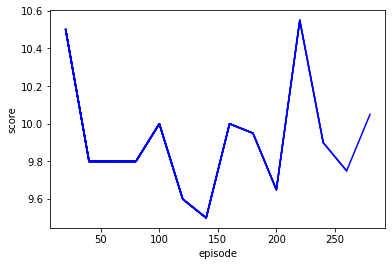

In [5]:
# libraries
import gym
import collections
import random

# pytorch library is used for deep learning (딥러닝 라이브러리, 대세인 파이토치)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# hyperparameters
learning_rate = 0.0005
gamma = 0.98
buffer_limit = 50000        # size of replay buffer
batch_size = 32

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)    # double-ended queue
    
    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n): # 32개의 배치사이즈를 랜덤하게 가져오는 함수 
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition # done_mask는 터미널인지 아닌지 구분, (s,a,r,s_prime 한 세트가 transition이다.)
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)

class DuelingQnet(nn.Module):
    def __init__(self):
        super(DuelingQnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc_value = nn.Linear(128, 128)
        self.fc_adv = nn.Linear(128, 128)
        self.value = nn.Linear(128, 1)
        self.adv = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        v = F.relu(self.fc_value(x))
        a = F.relu(self.fc_adv(x))
        v = self.value(v)
        a = self.adv(a)
        a_avg = torch.mean(a)
        q = v + a - a_avg
        return q

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()  

class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128) # cartpole는 input이 4개, hidden layer가 128개
        self.fc2 = nn.Linear(128, 128) # hidden layer가 128개
        self.fc3 = nn.Linear(128, 2) # output이 2개

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()   

def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size) # 리플레이버퍼에서 32개를 꺼내온다

        q_out = q(s) # 꺼내온 것중 state들을 온라인 네트워크에 넣어서 결과를 얻어라.
        q_a = q_out.gather(1,a) 

        # DQN
        #max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1) # 타켓 Q값 계산하는 부분

        # Double DQN
        argmax_Q = q(s_prime).max(1)[1].unsqueeze(1)
        max_q_prime = q_target(s_prime).gather(1, argmax_Q)

        target = r + gamma * max_q_prime * done_mask
        
        # MSE Loss
        loss = F.mse_loss(q_a, target)

        # Smooth L1 Loss
        #loss = F.smooth_l1_loss(q_a, target)

        # 아래 3개의 함수를 호출하면 파라미터를 업데이트함
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

def main():
    env = gym.make('CartPole-v1')
    q = DuelingQnet() # 온라인 Q (예측 Q)
    q_target = DuelingQnet() # 타켓 Q
    q_target.load_state_dict(q.state_dict()) # Q의 파라미터를 Q_Target으로 복사해준다.
    memory = ReplayBuffer()

    print_interval = 20
    score = 0.0
    scores = []
    episodes = []
    optimizer = optim.Adam(q.parameters(), lr=learning_rate) #  stochastic gradient descent 방식 (딥러닝 영역)

    for n_epi in range(300):
        epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #Linear annealing from 8% to 1%
        s = env.reset()
        done = False
        
        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, done, info = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.0,s_prime, done_mask))
            s = s_prime

            score += r
            if done:
                break

        if memory.size()>2000:
            train(q, q_target, memory, optimizer)

        if n_epi%print_interval==0 and n_epi!=0:
            q_target.load_state_dict(q.state_dict()) # Q target쪽으로 copy

            scores.append(score/print_interval)
            episodes.append(n_epi)
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                                                            n_epi, score/print_interval, memory.size(), epsilon*100))
            plt.plot(episodes, scores, 'b')
            plt.xlabel('episode')
            plt.ylabel('score')
            plt.savefig('cartpole_graph.png')

            score = 0.0
            
        

            

    env.close()

if __name__ == '__main__':
    main()